### Initial verification against existing E3SM data
All verifications are done for the year 2014

In [ ]:
## All necessary imports
import xarray as xr
import numpy as np
from pathlib import Path
from datetime import datetime
from ggen.gen_scrip_file import gen_scrip
from ggen.driver_mod import driver

**Declare conversion factors and constants**</br>
- Convert molec/cm2/s to kg/m2/s </br>
emis [molec/cm2/s] * mw[g/mole] * 1.e-3[kg/g] * 1/Avog[molecules/mole] * 1e4 [cm2/m2] = emis * 10 * mw [kg/m2/s]</br>
[molec/cm2] * [g/mole] * [kg/g] * [mole/molec] * [cm2/m2] = kg/m2

In [36]:
avgod = 6.022e+23 # Avogadro's constant
mw = 12 # for BC/POM; 64 for SO2; 115 for so4
factaaa = 10*mw/avgod # molec/cm2/s to kg/m2/s
factbb  = 86400.0*365.0*1e-9 # kg/m2/s to Tg/m2/yr

# start and end years
start = 2014
end = 2014

### Checking Original input4cmip CEDS data
Source: https://esgf-node.llnl.gov/search/input4mips/ </br>
Institution ID: PNNL-JGCRI</br>
Product year: 2017</br>
Reference: https://gmd.copernicus.org/articles/11/369/2018/ </br>
Filename format: species-em-anthro_input4MIPs_emissions_CMIP_CEDS-2017-05-18*

In [39]:
# Grid cell-area (0.5x0.5 deg) for area-weighted calculation
grid = xr.open_dataset('gridarea_CEDS.nc')['cell_area']
# Actual CEDS data
data = xr.open_dataset('BC-em-anthro_input4MIPs_emissions_CMIP_CEDS-2017-05-18_gn_200001-201412.nc').sel(time=slice(str(start),str(end)))
emis = data['BC_em_anthro'].sum('time')*grid*factbb/12 # kg/m2/s to Tg/yr
items_data = data['sector'].ids.split(';')

# Global total emission in 2014
i=0
for sect in items_data:
    print(sect,emis[i].sum(['lat','lon']).values)
    i+=1

print('Total:',emis.sum(emis.dims).values,'Tg/yr')

0: Agriculture 0.0
 1: Energy 1.1916707456145224
 2: Industrial 0.8375447494730383
 3: Transportation 1.4134083911202706
 4: Residential, Commercial, Other 3.719414213584964
 5: Solvents production and application 0.0
 6: Waste 0.6782643179389352
 7: International Shipping 0.16645534249874294
Total: 8.006757760230478 Tg/yr


**Compare with E3SM high-res data**

In [35]:
# Grid cell-area for area-weighted calculation
old_grid = xr.open_dataset('gridarea_RLL.nc')['cell_area']
# E3SM high-res data
old_data = xr.open_dataset('bc_a4_HR_emis_2014.nc')
old_emis = old_data*factaaa*factbb*old_grid/12
print(old_emis.sum(old_emis.dims).values) # Global total emission in 2014

<bound method Mapping.values of <xarray.Dataset>
Dimensions:  ()
Data variables:
    AGR      float64 0.0
    ENE      float64 1.192
    IND      float64 0.8371
    TRA      float64 1.413
    RCO      float64 3.719
    SLV      float64 0.0
    WST      float64 0.6782
    SHP      float64 0.1665
    bc_a4    float64 8.005>


In [38]:
## grabbing sector info and assigning E3SM sector identifiers
orig_sectors = {'Agriculture': 'AGR',
         'Energy': 'ENE',
         'Industrial': 'IND',
         'Transportation': 'TRA',
         'Residential, Commercial, Other': 'RCO',
         'Solvents production and application': 'SLV',
         'Waste': 'WST',
         'International Shipping': 'SHP'}

items_data = data['sector'].ids.split(';')
keys = []
values = []
for item in items_data:
    values.append(int(item.split(':')[0]))
    keys.append(orig_sectors[item.split(':')[1].strip()])
sectors = dict(zip(keys, values))
sectors

{'AGR': 0,
 'ENE': 1,
 'IND': 2,
 'TRA': 3,
 'RCO': 4,
 'SLV': 5,
 'WST': 6,
 'SHP': 7}

In [40]:
## Get date array
years = np.arange(1849,2023)
dates = np.zeros(len(years)*12,dtype=np.int32)
for i in range(len(years)):
    dates[i*12:(i+1)*12] = np.arange(18490115+i*1e4,18491315+i*1e4,100,dtype=np.int32)
dates

array([18490115, 18490215, 18490315, ..., 20221015, 20221115, 20221215],
      dtype=int32)

### Produce surface emissions from CEDS data 
Generate the data variables, coordinates, and attributes bases on the original CEDS data.

In [43]:
orig_varname = 'BC_em_anthro' # for BC; for SO2/SO4 SO2_em_anthro; for POM OC_em_anthro
## Select dates for the year 2014
dates = dates[np.where((dates>=int(start)*1e4+115) & (dates<=int(end)*1e4+1215))]

## Insert variables (date and sectors)
data_vars = {'date':(['time'], dates)}
for sect in sectors.keys():
    new_var = {sect:(['time','lat','lon'], data[orig_varname].sel(time=slice(str(start),str(end)))[:,sectors[sect]].data/factaaa,{'units': 'molecules/cm2/s'})}
    data_vars.update(new_var)
## Define coordinates
coords = {
          'lat': (['lat'], np.array(data['lat'].data, dtype=np.float32),{'units': 'degrees_north', 'long_name':'latitude','_FillValue':False}),
          'lon': (['lon'], np.array(data['lon'].data, dtype=np.float32),{'units': 'degrees_east', 'long_name':'longitude','_FillValue':False})
          }
## Define attributes
attrs = {
        'comment':'This data was produced using the new E3SM emission pre-processor',
        'contact':'Taufiq Hassan (taufiq.hassan@pnnl.gov)',
        'creation_date':datetime.today().strftime('%Y-%m-%d %H:%M:%S'),
        'grid':data.attrs['grid'],
        'nominal_resolution':data.attrs['nominal_resolution'],
        }


In [44]:
## Apply the data variables and output to netcdf with proper encoding
ds = xr.Dataset(data_vars=data_vars, coords=coords, attrs=attrs)
## Make time coordinate unlimited
ds.encoding = {'unlimited_dims': {'time'}}
## Remove _FillValue to match original data
comp = dict(_FillValue=None)
## Apply encoding to all variables
encoding = {var: comp for var in ds.data_vars}
## Save in netcdf
ds.to_netcdf('test_verif.nc',encoding=encoding)

In [45]:
## Checkout the new dataset
new_emis = xr.open_dataset('test_verif.nc')
new_emis

<xarray.Dataset>
Dimensions:  (time: 12, lat: 360, lon: 720)
Coordinates:
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * lon      (lon) float32 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
Dimensions without coordinates: time
Data variables:
    date     (time) int32 ...
    AGR      (time, lat, lon) float32 ...
    ENE      (time, lat, lon) float32 ...
    IND      (time, lat, lon) float32 ...
    TRA      (time, lat, lon) float32 ...
    RCO      (time, lat, lon) float32 ...
    SLV      (time, lat, lon) float32 ...
    WST      (time, lat, lon) float32 ...
    SHP      (time, lat, lon) float32 ...
Attributes:
    comment:             This data was produced using the new E3SM emission p...
    contact:             Taufiq Hassan (taufiq.hassan@pnnl.gov)
    creation_date:       2023-06-07 08:31:25
    grid:                0.5x0.5 degree latitude x longitude
    nominal_resolution:  50 km

In [47]:
## Check Global total emission in 2014 in the new dataset for all sectors
new_emis_test = new_emis.sum('time')*factaaa*factbb*grid/12
print(new_emis_test.sum(new_emis_test.dims).values)

<bound method Mapping.values of <xarray.Dataset>
Dimensions:  ()
Data variables:
    date     float64 0.06456
    AGR      float64 0.0
    ENE      float64 1.192
    IND      float64 0.8375
    TRA      float64 1.413
    RCO      float64 3.719
    SLV      float64 0.0
    WST      float64 0.6783
    SHP      float64 0.1665>


### Produce elevated emissions (forcings) from GFED data 
Source: https://esgf-node.llnl.gov/search/input4mips/ </br>
Institution ID: VUA</br>
Reference: https://gmd.copernicus.org/articles/10/3329/2017/ </br>
Filename format: species-em-biomassburning_input4MIPs_emissions_CMIP_VUA-CMIP-BB4CMIP6*

In [50]:
## Injection heights in km (mid-level) from already existing data
altitude_air = np.array([0.063000001013279, 0.202000007033348, 0.36599999666214,0.554000020027161, \
0.767000019550323, 1.00300002098083, 1.26199996471405,1.64100003242493, \
2.23200011253357, 3.02500009536743, 4.00899982452393,5.15700006484985, \
6.35599994659424], dtype=np.float64)
## Calculte the interfaces heights based on the mid-level heights
altitude_int_air = np.zeros(len(altitude_air)+1,dtype=np.float64)
for i in range(len(altitude_air)):
    altitude_int_air[i+1] = altitude_air[i]*2 - altitude_int_air[i]
## Get layer heights and assign coord altitude
dz = (altitude_int_air[1:] - altitude_int_air[:-1])*1e5 # km to cm
zcol = xr.DataArray(dz,coords={'altitude': altitude_air},dims=["altitude"])
zcol

<xarray.DataArray (altitude: 13)>
array([ 12600.00020266,  15200.00100136,  17599.9969244 ,  20000.0077486 ,
        22599.99215603,  24600.00813007,  27199.98061657,  48600.0329256 ,
        69599.98309612,  89000.01347065, 107799.93236065, 121800.11570453,
       117999.86064435])
Coordinates:
  * altitude  (altitude) float64 0.063 0.202 0.366 0.554 ... 4.009 5.157 6.356

### Using old E3SM emission data for the fractional distribution
Ideally, we want the whole process to be as independeent as possible. </br>
**How do we estimate the fractional disribution?**</br>
* Use inteerpolated AEROCOM profiles from original GFED data (e.g.; GFED_average_1997-2002_*.nc files)
* Use new profiles (e.g.; 2008 MISR)

In [52]:
## Fire emis profile and fraction from old file
elev_data = xr.open_dataset('bc_a4_elev_HR_emis_profile.nc')
fire = elev_data['BB']
fire['altitude'] = zcol['altitude']
fire.encoding['_FillValue'] = 9.96921e+36
temp = fire*zcol/(fire*zcol).sum('altitude')
## Fractions over the missing value regions 
fractions = np.zeros(len(zcol))
fractions[:9] = [0.25,0.15,0.15,0.1,0.1,0.1,0.05,0.05,0.05]
## Apply fractions
for i, frac in zip(range(len(zcol)),fractions):
    temp[:,i,:,:] = np.where(np.isnan(temp[:,i,:,:]),frac,temp[:,i,:,:])

temp.name = 'frac'
data_vars = {
            'frac':(['time','altitude','lat','lon'], temp.data,{'units': 'fractions','_FillValue':9.96921e+36})
            }
coords = {
          'altitude': (['altitude'], np.array(fire['altitude'].data, dtype=np.float32),{'units': 'km', 'long_name':'altitude','_FillValue':9.96921e+36}),
          'lat': (['lat'], np.array(fire['lat'].data, dtype=np.float32),{'units': 'degrees_north', 'long_name':'latitude','_FillValue':9.96921e+36}),
          'lon': (['lon'], np.array(fire['lon'].data, dtype=np.float32),{'units': 'degrees_east', 'long_name':'longitude','_FillValue':9.96921e+36})
          }
ds = xr.Dataset(data_vars=data_vars, coords=coords)
ds.load().to_netcdf('bc_a4_vert_profile_HR.nc')
ds

<xarray.Dataset>
Dimensions:   (time: 12, altitude: 13, lat: 384, lon: 576)
Coordinates:
  * altitude  (altitude) float32 0.063 0.202 0.366 0.554 ... 4.009 5.157 6.356
  * lat       (lat) float32 -90.0 -89.53 -89.06 -88.59 ... 89.06 89.53 90.0
  * lon       (lon) float32 0.0 0.625 1.25 1.875 2.5 ... 357.5 358.1 358.8 359.4
Dimensions without coordinates: time
Data variables:
    frac      (time, altitude, lat, lon) float64 0.25 0.25 0.25 ... 0.0 0.0 0.0

In [11]:
## original biomass burning data
biomass = xr.open_dataset('BC-em-biomassburning_input4MIPs_emissions_CMIP_VUA-CMIP-BB4CMIP6-1-2_gn_185001-201512.nc').sel(time=slice(str(start),str(end)))
data_biom = biomass['BC']
lon_biom = data_biom['longitude']
lat_biom = data_biom['latitude']
data_biom.encoding['_FillValue'] = 9.96921e+36
data_biom.encoding['missing_value'] = 9.96921e+36
data_biom = data_biom.rename({'latitude':'lat','longitude':'lon'})
data_biom

<xarray.DataArray 'BC' (time: 12, lat: 720, lon: 1440)>
[12441600 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 89.88 89.62 89.38 89.12 ... -89.38 -89.62 -89.88
  * lon      (lon) float64 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * time     (time) object 2014-01-16 12:00:00 ... 2014-12-16 12:00:00
Attributes:
    long_name:      biomass burning BC emissions
    standard_name:  biomass_burning_carbon_flux
    units:          kg m-2 s-1
    cell_methods:   time: mean

### Use `ggen` features to remap data to uniform resolution
Move remapping step to an earlier stage, preferably on the original dataset.

In [3]:
## Remap to orig data resolution (0.25)
out_scrip = gen_scrip(file='BC-em-biomassburning_input4MIPs_emissions_CMIP_VUA-CMIP-BB4CMIP6-1-2_gn_185001-201512.nc',fdir='/Users/hass877/Work/data_analysis',path='/Users/hass877/Work/data_analysis',xdim='longitude',ydim='latitude',nc=True).get_scrip_file()
print(out_scrip)
driver(file='bc_a4_vert_profile_HR.nc',ind='/Users/hass877/Work/data_analysis',out='/Users/hass877/Work/data_analysis',grid=str(out_scrip),res='720x1440').gen_remapped_files()


/Users/hass877/Work/data_analysis/RLL720x1440_SCRIP.nc


In [53]:
## test new profile data
new_prof = xr.open_dataset('bc_a4_vert_profile_HR_RLL384x576_RLL720x1440.nc',drop_variables=['lat','lon'])['frac']
new_prof['lon'] = lon_biom.values
new_prof['lat'] = lat_biom.values
grid_p25 = xr.open_dataset('gridarea_p25.nc')['cell_area']
new_vals = []
for lev in range(len(new_prof.altitude)):
    new_vals.append(int(1e7*((new_prof[8,lev]*grid_p25).sum(grid_p25.dims)/grid_p25.sum(grid_p25.dims)).data))

print(new_prof.altitude)
altitude_air = new_prof.altitude
altitude_int_air = np.zeros(len(altitude_air)+1,dtype=np.float64)
for i in range(len(altitude_air)):
    altitude_int_air[i+1] = altitude_air[i]*2 - altitude_int_air[i]

dz = (altitude_int_air[1:] - altitude_int_air[:-1])*1e5 # km to cm
zcol = xr.DataArray(dz,coords={'altitude': altitude_air},dims=["altitude"])
zcol

<xarray.DataArray 'altitude' (altitude: 13)>
array([0.063, 0.202, 0.366, 0.554, 0.767, 1.003, 1.262, 1.641, 2.232, 3.025,
       4.009, 5.157, 6.356], dtype=float32)
Coordinates:
  * altitude  (altitude) float32 0.063 0.202 0.366 0.554 ... 4.009 5.157 6.356
Attributes:
    units:      km
    long_name:  altitude


<xarray.DataArray (altitude: 13)>
array([ 12600.00020266,  15200.00100136,  17599.9969244 ,  20000.0077486 ,
        22599.99215603,  24600.00813007,  27199.98061657,  48600.03292561,
        69599.98309612,  89000.01347065, 107799.93236065, 121800.11570454,
       117999.86064434])
Coordinates:
  * altitude  (altitude) float32 0.063 0.202 0.366 0.554 ... 4.009 5.157 6.356

In [54]:
## vs old data
old_vals = []
for lev in range(len(temp.altitude)):
    old_vals.append(int(1e7*((temp[8,lev]*old_grid).sum(old_grid.dims)/old_grid.sum(old_grid.dims)).data))

assert new_vals==old_vals


### Produce the elevated data based on the GFED data, profiles from old data, and vertical layer heights

In [56]:
bc_elev_emis = new_prof*data_biom.fillna(0)/factaaa/zcol
bc_elev_emis

<xarray.DataArray (time: 12, altitude: 13, lat: 720, lon: 1440)>
array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
...
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]]])
Coordinates:
  * time      (time) object 2014-01-16 12:00:00 ... 2014-12-16 12:00:00
  * altitude  (altitude) float32 0.063 0.202 0.366 0.554 ... 4.009 5.157 6.356
  * lon       (lon) float64 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * lat       (lat) float64 89.88 89.62 89.38 89.12 ... -89.38 -89.62 -89.88

### Plot the old vs new elevated emission data

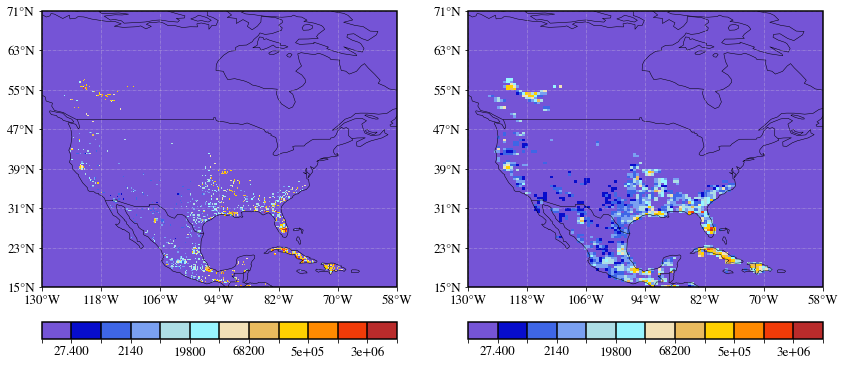

In [65]:
from aerdiag_plots import get_plots
import matplotlib.pyplot as plt
import cmaps
import cartopy.crs as crs
#bc_elev_emis[0,0].plot(robust=True)
rr=[0,0.000274,0.00307,0.0214,0.0793,.198,.392,.682,1.13,5,10,32.9,50]
rr = np.array(rr)*1e5
fig=plt.figure(figsize=(14,12))
ax = plt.subplot(121,projection=crs.PlateCarree())
get_plots( bc_elev_emis[0,0],ax=ax,cmap=cmaps.amwg256,levels=rr,\
             scrip_file='',gridLines=False,cbs=5,cbe=-20,cbi=2,\
                lon_range=[-130,-60], lat_range=[15,65],
                unit='',colbar=True).get_map()

ax = plt.subplot(122,projection=crs.PlateCarree())
get_plots( fire[0,0],ax=ax,cmap=cmaps.amwg256,levels=rr,\
             scrip_file='',gridLines=False,cbs=5,cbe=-20,cbi=2,\
                lon_range=[-130,-60], lat_range=[15,65],
                unit='',colbar=True).get_map()

In [66]:
## verify new elev data
grid_p25 = xr.open_dataset('gridarea_p25.nc')['cell_area']
new_vals = []
for lev in range(len(bc_elev_emis.altitude)):
    new_vals.append(int(1*((bc_elev_emis[5,lev]*grid_p25).sum(grid_p25.dims)/grid_p25.sum(grid_p25.dims)).data))
## vs old data
old_vals = []
for lev in range(len(fire.altitude)):
    old_vals.append(int(1*((fire[5,lev]*old_grid).sum(old_grid.dims)/old_grid.sum(old_grid.dims)).data))
print('old:',old_vals)
print('new:',new_vals)   

old: [10417, 3943, 3928, 3360, 3196, 1655, 167, 159, 167, 78, 2, 2, 0]
new: [10416, 3943, 3929, 3360, 3196, 1655, 167, 159, 167, 78, 2, 2, 0]


In [71]:
## Generate the data variables, coordinates, and attributes
dates = dates[np.where((dates>=int(start)*1e4+115) & (dates<=int(end)*1e4+1215))]
data_vars = {'date':(['time'], dates)}
for sect in ['BB']:
    new_var = {sect:(['time','altitude','lat','lon'], bc_elev_emis.data,{'units': 'molecules/cm3/s'})}
    data_vars.update(new_var)

coords = {
          'altitude': (['altitude'], altitude_air.data,{'units': 'km', 'long_name':'altitude midlevel','_FillValue':False}),
          'altitude_int': (['altitude_int'], altitude_int_air.data,{'units': 'km', 'long_name':'altitude interval','_FillValue':False}),
          'lat': (['lat'], np.array(data_biom['lat'].data, dtype=np.float32),{'units': 'degrees_north', 'long_name':'latitude','_FillValue':False}),
          'lon': (['lon'], np.array(data_biom['lon'].data, dtype=np.float32),{'units': 'degrees_east', 'long_name':'longitude','_FillValue':False})
          }
attrs = {
        'comment':'This data was produced using the new E3SM emission pre-processor',
        'contact':'Taufiq Hassan (taufiq.hassan@pnnl.gov)',
        'creation_date':datetime.today().strftime('%Y-%m-%d %H:%M:%S'),
        'grid':biomass.attrs['grid'],
        'nominal_resolution':biomass.attrs['nominal_resolution'],
        }


In [72]:
## Apply the data variables and output to netcdf with proper encoding
ds = xr.Dataset(data_vars=data_vars, coords=coords, attrs=attrs)
ds.encoding = {'unlimited_dims': {'time'}}
comp = dict(_FillValue=None)
encoding = {var: comp for var in ds.data_vars}
ds.to_netcdf('test_elev_verif.nc',encoding=encoding)
ds

<xarray.Dataset>
Dimensions:       (time: 12, altitude: 13, lat: 720, lon: 1440, altitude_int: 14)
Coordinates:
  * altitude      (altitude) float32 0.063 0.202 0.366 ... 4.009 5.157 6.356
  * altitude_int  (altitude_int) float64 0.0 0.126 0.278 ... 4.548 5.766 6.946
  * lat           (lat) float32 89.88 89.62 89.38 89.12 ... -89.38 -89.62 -89.88
  * lon           (lon) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Dimensions without coordinates: time
Data variables:
    date          (time) int32 20140115 20140215 20140315 ... 20141115 20141215
    BB            (time, altitude, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    comment:             This data was produced using the new E3SM emission p...
    contact:             Taufiq Hassan (taufiq.hassan@pnnl.gov)
    creation_date:       2023-06-07 11:29:28
    grid:                0.25x0.25 degree latitudexlongitude
    nominal_resolution:  25 km

### For number concentrations multiply a factor
The factor is a function of particle density [rho], mw, and diameter [diam]</br>
**convert molec/cm2/s to (particles/cm2/s) * 6.022e26** </br>
emis [molec/cm2/s] * 1/Avog[molecules/mole] * mw[g/mole] * 1.e-3[kg/g] * rho[kg/m3] * 1/diam[m3]</br>
[molec/cm2/s] * [mole/molecules] * [g/mole] * [kg/g] * [m3/kg] * [1/m3] * 6.022e26[particles] = (particles/cm2/s) * 6.022e26</br>
num_factor = mw/avgod/rho/((1/6)*np.pi*(diam*1e-6)**3)*1e-3*6.022e26

This factor is defined as:
```console
def get_num_factor(mw, rho, diam):
    avgod = 6.022e23
    num_factor = mw/avgod/rho/((1/6)*np.pi*(diam*1e-6)**3)*1e-3*6.022e26
    return num_factor
```

**Compare 2014 old vs new num_a4 files**

In [73]:
old_grid = xr.open_dataset('gridarea_RLL.nc')['cell_area']
old_data = xr.open_dataset('num_a4_HR_emis_2014.nc')
old_emis = old_data*factaaa*factbb*old_grid/12
print(old_emis.sum(old_emis.dims).values) # Global total emission in 2014

<bound method Mapping.values of <xarray.Dataset>
Dimensions:         ()
Data variables: (12/17)
    num_a1_BC_AGR   float64 0.0
    num_a1_BC_ENE   float64 6.676e+18
    num_a1_BC_IND   float64 4.69e+18
    num_a1_BC_RCO   float64 2.084e+19
    num_a1_BC_SHP   float64 9.33e+17
    num_a1_BC_SLV   float64 0.0
    ...              ...
    num_a1_POM_RCO  float64 1.488e+20
    num_a1_POM_SHP  float64 1.688e+18
    num_a1_POM_SLV  float64 0.0
    num_a1_POM_TRA  float64 8.565e+18
    num_a1_POM_WST  float64 5.641e+19
    num_a4          float64 3.073e+20>


In [77]:
old_grid = xr.open_dataset('gridarea_CEDS.nc')['cell_area']
new_data = xr.open_dataset('num_a4_E3SM_surf_emis.nc')
new_emis = new_data*factaaa*factbb*old_grid/12
print(new_emis.sum(new_emis.dims).values) # Global total emission in 2014

<bound method Mapping.values of <xarray.Dataset>
Dimensions:         ()
Data variables: (12/17)
    date            float64 0.06456
    num_a1_BC_AGR   float64 0.0
    num_a1_BC_ENE   float64 6.677e+18
    num_a1_BC_IND   float64 4.693e+18
    num_a1_BC_TRA   float64 7.919e+18
    num_a1_BC_RCO   float64 2.084e+19
    ...              ...
    num_a1_POM_IND  float64 1.961e+19
    num_a1_POM_TRA  float64 8.568e+18
    num_a1_POM_RCO  float64 1.489e+20
    num_a1_POM_SLV  float64 0.0
    num_a1_POM_WST  float64 5.641e+19
    num_a1_POM_SHP  float64 1.687e+18>
